<a href="https://colab.research.google.com/github/pierresegonne/ELEC5307_Project1/blob/master/project1_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTILS

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=91e89ca49532cf4631cf7fafc77ba32199e3b2bcadb7a68b42e0722389bb1424
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 154.0 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
# Install pytorch

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Accelerator: ', accelerator)

print('Installing Torch') 
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl
# Issue with torchvision version
!pip install torchvision==0.2.1
import torch
import torchvision

Accelerator:  cu80
Installing Torch


In [0]:
ROOT_DIRECTORY = '.'

In [2]:
# Allow saving files to google drive if ran on colab
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIRECTORY = '/content/gdrive/My Drive/Colab Notebooks/ELEC5307 Project1'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# IMPORTS

In [0]:
# useful packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
import torch.optim as optim


import numpy as np
import math
import random

import matplotlib.pyplot as plt

import os
import pickle


# HYPERPARAMETERS

In [0]:
LEARNING_RATE = 0.001
BATCH_SIZE = 8
EPOCHS = 16

CROP_SIZE=24

# CODE

## 1st Influence: Data Transformation

In [26]:
"""
Modification of the transformations
Choice          Parameters
---------------------------
Center Crop     size
Five Crop       size
Resize          size + interpolation
"""
transform_original = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_centercrop = transforms.Compose(
    [# Cropping
     transforms.CenterCrop(CROP_SIZE),
     transforms.Resize(32),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def handleFiveCrops(crops):
    # original 
    # return torch.stack([ToTensor()(crop) for crop in crops])
    tensor_stack = []
    for crop in crops:
        new_tensor = transforms.Compose([
                                       transforms.Resize(32),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])(crop)
        tensor_stack.append(new_tensor)
    return torch.stack(tensor_stack)

def randomFromFiveCrops(crops):
    randomIndex = random.randint(0,len(crops)-1)
    return crops[randomIndex]

transform_fivecrop = transforms.Compose(
    [# Cropping
     transforms.FiveCrop(22),
     # transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
     transforms.Lambda(lambda crops: handleFiveCrops(crops)),
     ])

transform_modified = transforms.RandomChoice([
    transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    transforms.Compose([
                        transforms.FiveCrop(24), # What choice here?
                        transforms.Lambda(lambda crops: randomFromFiveCrops(crops)),
                        transforms.Resize(32),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),                     
  ])


# data_transform = transform_modified
data_transform = transform_original

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

test_transform = transforms.ToTensor()

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([4, 3, 32, 32])
truck  deer  ship   dog


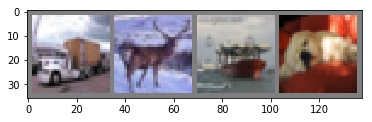

In [27]:
def showimg(tensor):
    tensor = tensor / 2 + 0.5     # unnormalize, because normalization is (img - 0.5)/0.5 in transforms.Normalize
    npimg = tensor.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Visualization of random training images
dataiter = trainloader.__iter__()
input, labels = dataiter.next()

# ------
# IF FIVE CROPS TOTAL
# bs, ncrops, c, h, w = input.size()
# input = input.view(-1, c, h, w) # fuse crops and bs
# if include the five crop, how to handle the difference in shapes with at random?
# Can just have a switch, if five crops, multiplies the bs by 5.
# ------

print(input.shape)
# show images
showimg(torchvision.utils.make_grid(input))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Generate the Test/Validation Split to monitor training

In [0]:
VALIDATION_SET_SIZE = 5000
ACCELERATED_TRAINING = False

if ACCELERATED_TRAINING:
    SCALING_FACTOR = 100
    indices = np.arange(int(len(trainset)/SCALING_FACTOR)) # Reduce size of the dataset by a factor 10 for quicker parameter evaluation!
    np.random.shuffle(indices) # for shuffle = True
    split = int(len(indices)*0.8) # Can't use 5000 values for validation, use more traditional 80/20 split
    RECORD_EVERY = int(2000 / SCALING_FACTOR)
else:
    indices = np.arange(len(trainset))
    np.random.shuffle(indices) # for shuffle = True
    split = len(trainset) - VALIDATION_SET_SIZE
    RECORD_EVERY = int(2000 * (8/BATCH_SIZE))


validation_set_size = len(indices) - split

train_sampler, validation_sampler = SubsetRandomSampler(indices[:split]), SubsetRandomSampler(indices[split:])

##2nd Influence: Network Structure

In [0]:
"""
Initial Output Channels
"""
I_C = 16
DL_C = 1024

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # define the network layers

        # nn.Conv2d(input_channel, output_channel, filter_size,
        #     stride=stride, padding=padding)
        # By default, padding=0, stride=1
        # CIFAR 10 is 32*32*3
        # Pooling Method, Kernel size, dropout and activation method shall not be experimented with.

        self.conv1 = nn.Conv2d(3,I_C,5)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(I_C, I_C*4, 5)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(I_C*4, I_C*4*4, 5)
        self.pool3 = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(I_C*4*4,DL_C)
        self.fc2 = nn.Linear(DL_C,DL_C)
        self.fc3 = nn.Linear(DL_C,10)

    def forward(self, x):
        # define the network structure
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))

        # Reshape
        x = x.view(-1,I_C*4*4)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

cnn = CNN()
if torch.cuda.is_available():
  cnn.cuda()

# test
# REMINDER, shape of tensor: [BS, CH, HEIGHT, WIDTH]
TEST_INPUT = True
if TEST_INPUT:
    input = torch.rand((1,3,32,32))
    if torch.cuda.is_available():
        input = input.cuda()
    print(cnn(input))

tensor([[ 0.0035,  0.0077,  0.0210,  0.0166, -0.0083,  0.0120,  0.0133, -0.0044,
          0.0131, -0.0180]], device='cuda:0', grad_fn=<AddmmBackward>)


## 3rd Influence: Optimizer

https://arxiv.org/pdf/1506.01186.pdf cyclical lr -> implementation

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=LEARNING_RATE, momentum=0.9)
# optimizer = optim.SGD(cnn.parameters(), lr=1, momentum=0.9) # Important to put LR=1 here with CLR!!

# CLR
def cyclical_learning_rate(min_lr, max_lr, stepsize, mode='triangular'):
    if mode == 'triangular':
        scaler = lambda x: 1
    if mode == 'triangular2':
        scaler = lambda x: (1/2)**(x-1)

    lr_scheduler = lambda iteration: min_lr + (max_lr - min_lr)*eval(iteration, stepsize)

# What about exp? Shown not to yield significantly better results, more complex to implement so didn't

  def eval(iteration, stepsize):
    cycle = math.floor(1+(iteration/(2*stepsize)))
    x = abs(iteration/stepsize - 2*cycle +1)
    return max(0,(1-x))*scaler(cycle)

  return lr_scheduler

def manual_plateau(epoch):
    if epoch + 1 >= 12:
        return 0.5**3
    if epoch + 1 >= 8:
        return 0.5**2
    if epoch + 1 >= 4:
        return 0.5
    return 1

# Stepsize is good when = (Nbr iterations / epoch) * 2 ~ 10. We choose 2 multiplier.
stepsize = int(len(train_sampler) / BATCH_SIZE * 2) - 500
lambdaCLR = cyclical_learning_rate(LEARNING_RATE, LEARNING_RATE * 6, stepsize, mode='triangular')
lambdaSimple = lambda epoch: 0.9**epoch
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, [lambdaCLR])
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [manual_plateau])
# scheduler = None

# ===========

#### Training 

In [0]:
def serializeObject(obj, fileName):
    with open(fileName, 'wb') as fileHandler:
        pickle.dump(obj, fileHandler, protocol=pickle.HIGHEST_PROTOCOL)

def train_network(ann, train_loader, validation_loader,
                  optimizer, scheduler, criterion,
                  batch_size=2, lr=0.001, epoch=2,
                  download=False, root_directory='',
                  record_every=20):
    ann = ann.train()
    
    training_loss = []
    validation_loss = []  

    validation_set_size = len(validation_loader.sampler)

    for e in range(epoch):

        if type(scheduler).__name__ != 'NoneType':
            scheduler.step()
        
        print('Epoch {}, lr {}'.format(e+1, optimizer.param_groups[0]['lr']))

        running_loss = 0.
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = ann(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            # Scheduler step as well!
            # if type(scheduler).__name__ != 'NoneType':
            #     scheduler.step()
            optimizer.step()

            if torch.cuda.is_available():
                loss = loss.cpu()

            running_loss += loss.item()
            
            if i % record_every == (record_every - 1):
                print('[%d, %5d] loss: %.3f' %
                      (e + 1, i + 1, running_loss / record_every))
                # Training loss
                training_loss.append(running_loss / record_every)
                running_loss = 0.0
            
                # Validation loss
                running_validation_loss = 0
                for indices, data in enumerate(validation_loader, 0):
                    inputs, labels = data
                    if torch.cuda.is_available():
                        inputs, labels = inputs.cuda(), labels.cuda()
                    outputs = ann(inputs)
                    loss = criterion(outputs, labels)
                    if torch.cuda.is_available():
                        loss = loss.cpu()
                    running_validation_loss += loss.item()
                validation_loss.append(running_validation_loss / (validation_set_size/batch_size))
    
    
    if download:
        dir_name = '{0}/training_recording_part3/bs{1},lr{2},epoch{3}'.format(root_directory, batch_size, lr, epoch)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        
        # Save losses for eventual future use
        serializeObject(training_loss, dir_name + '/training_loss.pickle')
        serializeObject(validation_loss, dir_name + '/validation_loss.pickle')

        # Save network weights for eventual future use
        torch.save(ann.state_dict(), dir_name + '/network_weights.pth')
        
        iterations = np.arange(len(training_loss))*record_every
        plt.figure()
        plt.title('Training and Validation Loss During Training')
        plt.xlabel('Iterations')
        plt.ylabel('Loss Value')
        plt.plot(iterations, training_loss, '-', color='royalblue')
        plt.plot(iterations, validation_loss, '-', color='tomato')
        plt.legend(['Training', 'Validation'])
        plt.savefig(dir_name + '/e{0},lr{1},bs{2}.png'.format(epoch, lr, batch_size), bbox_inches='tight')

        
    
    return ann

#### Eval

In [0]:
def eval_net(net, testloader):
    net = net.eval()
    if torch.cuda.is_available():
        net = net.cuda()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            if torch.cuda.is_available():
                outputs = outputs.cpu()
                labels = labels.cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Own
    accuracy = 100 * correct / total
    
    print('Accuracy of the network on the 10000 test images: %d %%' % (accuracy))
    return accuracy

#### Run

Epoch 1, lr 0.001


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,  2000] loss: 2.228
[1,  4000] loss: 1.782
Epoch 2, lr 0.001
[2,  2000] loss: 1.415
[2,  4000] loss: 1.317
Epoch 3, lr 0.0005
[3,  2000] loss: 1.086
[3,  4000] loss: 1.058
Epoch 4, lr 0.0005
[4,  2000] loss: 0.952
[4,  4000] loss: 0.935
Epoch 5, lr 0.0005
[5,  2000] loss: 0.847
[5,  4000] loss: 0.848
Epoch 6, lr 0.0005
[6,  2000] loss: 0.755
[6,  4000] loss: 0.758
Epoch 7, lr 0.00025
[7,  2000] loss: 0.608
[7,  4000] loss: 0.606
Epoch 8, lr 0.00025
[8,  2000] loss: 0.535
[8,  4000] loss: 0.544
Epoch 9, lr 0.00025
[9,  2000] loss: 0.482
[9,  4000] loss: 0.500
Epoch 10, lr 0.00025
[10,  2000] loss: 0.421
[10,  4000] loss: 0.439
Epoch 11, lr 0.000125
[11,  2000] loss: 0.314
[11,  4000] loss: 0.327
Epoch 12, lr 0.000125
[12,  2000] loss: 0.271
[12,  4000] loss: 0.287
Epoch 13, lr 0.000125
[13,  2000] loss: 0.233
[13,  4000] loss: 0.254
Epoch 14, lr 0.000125
[14,  2000] loss: 0.203
[14,  4000] loss: 0.217
Epoch 15, lr 0.000125
[15,  2000] loss: 0.170
[15,  4000] loss: 0.186
Epoch 16, lr 

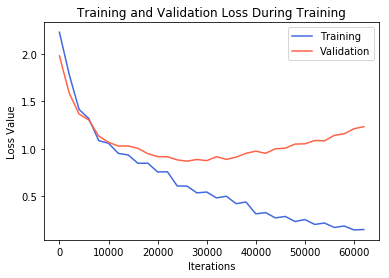

In [34]:
# cnn = CNN() # NEVER do that without reinstantianting the optimizer as well, discrepency between parameters and optimizer!

train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size=BATCH_SIZE,
                                           num_workers=2,
                                           sampler=train_sampler
                                          )
validation_loader = torch.utils.data.DataLoader(trainset,
                                                batch_size=BATCH_SIZE,
                                                num_workers=2,
                                                sampler=validation_sampler
                                               )

cnn = train_network(cnn, train_loader, validation_loader,
                    optimizer, scheduler, criterion,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, epoch=EPOCHS,
                    download=True, root_directory=ROOT_DIRECTORY,
                    record_every=RECORD_EVERY)

accuracy = eval_net(cnn, testloader)

#### RUNS

* baseline 1 62%
* baseline 2 62%
* baseline 3 61%

----

* Structure 16 69%, overfit at epoch = 5
* Structure 16 69%
* Structure 8 64%, overfit at epoch = 5
* Structure 4 62%, overfit at epoch = 5

----

* Structure 16 with large dense layers 70%
* Structure 16 with large dense layers 70%

----


* Structure 16 with plateau scheduler 71%
* Structure 16 with plateau scheduler + large dense layers 72% (1/2 at 5 and 10 epochs)
* Structure 16 with plateau scheduler + large dense layers 72% (1/2 at 5 and 10 epochs)
* Structure 16 with plateau scheduler + large dense layers 72% (1/10 at 5 and 10 epochs) -> less overfit from the curve

-
Note 45000/8 = 5625 iterations per epoch -> 
* Structure 16 with cyclical scheduler (tr) + large dense layers 70% (stepsize 2 epochs)
* Structure 16 with cyclical scheduler (tr) + large dense layers 69% (stepsize 2 epochs - 500)
* Structure 16 with cyclical scheduler (tr2) + large dense layers 72% (stepsize 2 epochs - 500)
* Structure 16 with cyclical scheduler (tr2) + large dense layers for 6 epochs 69% (stepsize 2 epochs - 500)
* Structure 16 with cyclical scheduler (tr2) + large dense layers for 10 epochs 70% (stepsize 2 epochs - 500)


----

* Structure 16 with plateau scheduler + large dense layers + five crops 63% (1/2 at 5 and 10 epochs)
* Structure 16 with plateau scheduler + large dense layers + five crops 62% (1/2 at 5 and 10 epochs)

these were 10 epochs!

* Structure 16 with plateau scheduler + large dense layers + five crops 65% (1/2 at 5 and 10 epochs)
* Structure 16 with plateau scheduler + large dense layers + five crops 65% (1/2 at 5 and 10 epochs)


